In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer

/Users/samcohen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## TODO:
* Record trials in an organized excel sheet, or write out each one to a .txt file 
* Save model parameters (allow for application after training and allow for updated training)


## Generate sine wave data points

In [90]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.1
points_per_cycle = int((2*np.pi) / sample_rate)

#Sample from a pure sine wave
data = [np.sin(i) for i in np.arange(start=0, stop=num_cycles*2*np.pi, step=sample_rate)]

print("Total data points: " + str(len(data)))

#Get the number of points for a clean multiple of some batch size
# print(int(len(data)/4))
# print(int(len(data)/4) * 4)
batch_size = 4



Total data points: 1257


## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [91]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [92]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 3
n_forecast = points_per_cycle

#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast# int(len(data)*0.2)


train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)

print("Train is a matrix. Rows=examples; Cols=total points in an example;   train.shape: " + str(train.shape))
print("Test is a vector of size total number of points in an example;       test size: " + str(len(test)))
print(n_prev)
print(n_forecast)


Train is a matrix. Rows=examples; Cols=total points in an example;   train.shape: (762, 248)
Test is a vector of size total number of points in an example;       test size: 248
186
62


## Visualize total dataset and goal in red

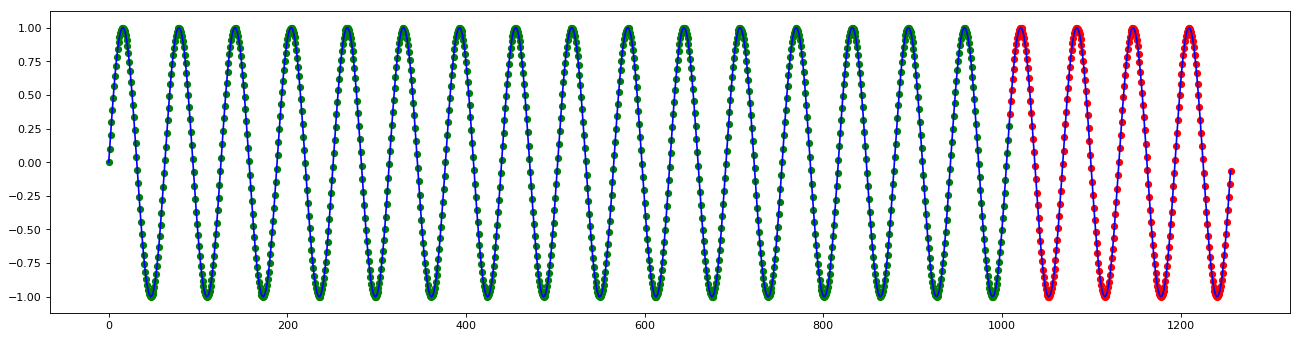

In [93]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Plot the original data using the defined train and test sizes
train_plot, test_plot = data[:-n_test], data[-n_test:]

#Line plot along the true data
plt.plot(data, color="blue")

#Plot the training points in green
train_plot_x = [x for x in range(len(train_plot))]
plt.scatter(train_plot_x, train_plot, color="green", s=30)

#Note: we have to shift the test data to plot it
test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
plt.scatter(test_plot_x, test_plot, color="red", s=30)


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [94]:
# fit an LSTM network to training data

def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    

    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print("sam")
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
    architecture += "LSTM; "
    #model.add(Dense(300))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #Fit the network to the training data
    for i in range(nb_epoch):
        start = timer()
        print(i)
        
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
        
        end = timer()
        print("Epoch duration: " + str(end - start))
    return model, architecture

## Train the Neural Network

In [116]:
n_epochs = 500
n_batch = 20
n_neurons = 1
print("train shape: " + str(train.shape))
train_cut = train[:-2,:]
print("train shape: " + str(train_cut.shape))

model, architecture = fit_lstm(train_cut, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


train shape: (762, 248)
train shape: (760, 248)
X shape: (760, 186)
y shape: (760, 62)
sam
(20, 186, 1)
(760, 186, 1)
0
Epoch duration: 6.425614370993571
1
Epoch duration: 4.152809320992674
2
Epoch duration: 4.365518303995486
3
Epoch duration: 4.2327030720043695
4
Epoch duration: 4.238019259006251
5
Epoch duration: 4.224476810995839
6
Epoch duration: 4.2524413610080956
7
Epoch duration: 4.272927611003979
8
Epoch duration: 4.2311808049998945
9
Epoch duration: 4.322484019008698
10
Epoch duration: 4.259555090000504
11
Epoch duration: 4.583618122996995
12
Epoch duration: 4.711786767002195
13
Epoch duration: 4.481238427004428
14
Epoch duration: 4.860592413009726
15
Epoch duration: 4.274407664997852
16
Epoch duration: 4.371732957995846
17
Epoch duration: 4.382688428988331
18
Epoch duration: 4.488053490000311
19
Epoch duration: 4.461173629999394
20
Epoch duration: 4.5065184280101676
21
Epoch duration: 4.521739328003605
22
Epoch duration: 4.555754487999366
23
Epoch duration: 4.681480325991288


Epoch duration: 5.494961903998046
217
Epoch duration: 5.518333647996769
218
Epoch duration: 5.532928778993664
219
Epoch duration: 5.3680384019971825
220
Epoch duration: 5.56204114400316
221
Epoch duration: 5.646831994992681
222
Epoch duration: 5.326290715005598
223
Epoch duration: 5.413309580006171
224
Epoch duration: 5.392812527003116
225
Epoch duration: 5.358031181996921
226
Epoch duration: 5.333609858993441
227
Epoch duration: 5.21882972100866
228
Epoch duration: 5.330689480993897
229
Epoch duration: 5.6069345050054835
230
Epoch duration: 5.137448034001864
231
Epoch duration: 5.680954915995244
232
Epoch duration: 5.357745763001731
233
Epoch duration: 5.4145458030106965
234
Epoch duration: 5.501932819010108
235
Epoch duration: 5.461503615006222
236
Epoch duration: 5.071621758004767
237
Epoch duration: 5.613082119001774
238
Epoch duration: 5.161465905999648
239
Epoch duration: 5.6493179660028545
240
Epoch duration: 5.140108609004528
241
Epoch duration: 5.283295300992904
242
Epoch dura

Epoch duration: 4.875599765000516
433
Epoch duration: 4.843646755005466
434
Epoch duration: 4.87108918800368
435
Epoch duration: 4.936286198004382
436
Epoch duration: 4.937142412993126
437
Epoch duration: 4.923569352002232
438
Epoch duration: 4.886640778000583
439
Epoch duration: 4.93232453300152
440
Epoch duration: 4.849777205003193
441
Epoch duration: 4.94038195500616
442
Epoch duration: 4.858372147005866
443
Epoch duration: 4.952541195991216
444
Epoch duration: 4.820486692013219
445
Epoch duration: 4.777779051000834
446
Epoch duration: 4.929059428992332
447
Epoch duration: 4.962452623993158
448
Epoch duration: 4.950661694005248
449
Epoch duration: 4.96091872100078
450
Epoch duration: 5.019462654003291
451
Epoch duration: 4.940241673990386
452
Epoch duration: 4.945070734000183
453
Epoch duration: 4.933502383006271
454
Epoch duration: 4.772611905995291
455
Epoch duration: 4.7255668209982105
456
Epoch duration: 4.939787672003149
457
Epoch duration: 4.931952915008878
458
Epoch duration:

In [117]:
print(train.shape)

(762, 248)


# 

In [118]:
def forecast_lstm(model, X, n_batch):
    #Reshape input data to [samples, timesteps, features] for the LSTM
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [119]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

186
(20, 186)
First true label: 0.1191951001872563
First forecast: -0.20270519
Average RMSE: 
0.23228215301125654


## Evaluate the forecast based on its RMSE and record results

In [120]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


RMSE: 
[0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530112564, 0.2322821530

## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

y size: 62
x size: 62
186
186
Epochs: 500
Average RMSE: 0.23228215301125654
Average predicted value: 0.003824532001970276
Variance of predicted values: 0.44151434
Min: -0.93463546 Max: 0.9346784


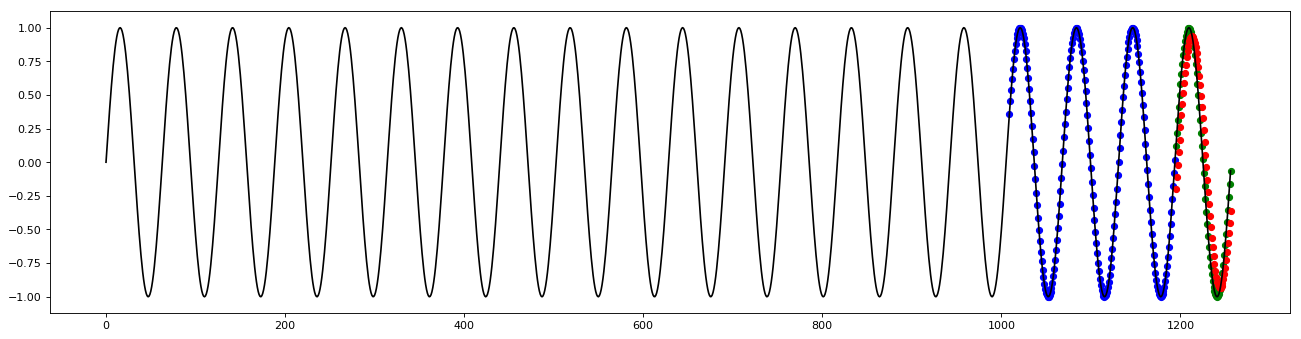

In [121]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))

In [51]:
from keras.models import Sequential
import numpy as np
from keras.layers import LSTM
from keras.layers import Dense
 
model = Sequential()
model.add(LSTM(2, input_shape=(2,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
 
x= np.array([[[1],[2]],[[3],[4]],[[5],[6]],[[7],[8]]])
y = np.array([1,2,3,4])
 
model.fit(x, y, nb_epoch=10, batch_size=2, verbose=1)


/Users/samcohen/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
4/4 [==============================] - 1s 287ms/step - loss: 8.9841
Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 8.9257
Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.8592
Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 8.7919
Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 8.7364
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 8.6759
Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 8.6077
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 8.5510
Epoch 9/10
4/4 [==============================] - 0s 2ms/step - loss: 8.4728
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 8.4180


In [52]:
print(model.predict([[[1],[3]], [[2],[4]], [[3],[5]]], batch_size=3))

AttributeError: 'list' object has no attribute 'ndim'

In [77]:
a = [1,2,3]
b = np.stack((a,a,a))
print(b.shape)

AttributeError: 'list' object has no attribute 'shape'